# Practical 6

### Clustering

Aim : Visualize the Data using clusters

The first step is to tokenize the summary column into words and remove all the stop words and punctuations<br>
this helps in clustering them on the words which are not common and hence it will produce a good quality clusters

In [83]:
def tokenizer(text):
    try:
        tokens_ = [word_tokenize(sent) for sent in sent_tokenize(text)]
        
        tokens = []
        for token_by_sent in tokens_:
            tokens += token_by_sent

        tokens = list(filter(lambda t: t.lower() not in stop, tokens))
        tokens = list(filter(lambda t: t not in punctuation, tokens))
        tokens = list(filter(lambda t: t not in [u"'s", u"n't", u"...", u"''", u'``', 
                                            u'\u2014', u'\u2026', u'\u2013'], tokens))
        filtered_tokens = []
        for token in tokens:
            if re.search('[a-zA-Z]', token):
                filtered_tokens.append(token)

        filtered_tokens = list(map(lambda token: token.lower(), filtered_tokens))

        return filtered_tokens
    except Error as e:
        print(e)

In [84]:
df=df.reset_index()

In [85]:
df['tokens']=df['summary'].map(tokenizer)

In [ ]:
for x in range(len(df['summary'])):
    counter =Counter(df['tokens'].iloc[x])
    print(x,counter.most_common(3))

After tokenizing each summary and by looking at the words it is clear that there are still some words which are common across the document
Hence the next step is to calculate the **Term Frequency - Inverse Document** Frequency to Identify only those words which has more weight in the document considering the entire corpus

In [87]:
vectorizer = TfidfVectorizer(min_df=10, max_features=10000, tokenizer=tokenizer, ngram_range=(1, 2))
vz = vectorizer.fit_transform(list(df['summary']))

In [88]:
vz

<68557x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 2168984 stored elements in Compressed Sparse Row format>

In [89]:
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
tfidf = pd.DataFrame(columns=['tfidf']).from_dict(dict(tfidf), orient='index')
tfidf.columns = ['tfidf']

In [90]:
tfidf.head()

,tfidf
aadhaar,7.844976
aadmi,6.451856
aadmi party,6.525964
aam,6.360884
aam aadmi,6.465554


After making the word matrix it is very clear that the number of columns will be huge and plotting them on the graph will be a challenge<br>
Therefore **Scalar Vector Decomposition** is used which will reduce the matrix to the given paramter i.e 50<br>
You might ask why 50 ,it is possibly to preserve the clusters

In [91]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=50, random_state=0)
svd_tfidf = svd.fit_transform(vz)

In [92]:
svd_tfidf.shape

(68557, 50)

After using the SVD on the sparse matrix, the new matrix is not sparse as the Original one and Now we can use **T-SNE** to reduce its dimensions to 2

In [ ]:
from sklearn.manifold import TSNE

tsne_model = TSNE(n_components=2, verbose=1, random_state=0)
tsne_tfidf = tsne_model.fit_transform(svd_tfidf)

In [94]:
tsne_tfidf.shape

(68557, 2)

In [95]:
import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook

In [96]:
output_notebook()
plot_tfidf = bp.figure(plot_width=700, plot_height=600, title="tf-idf default clustering of the news",
    tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
    x_axis_type=None, y_axis_type=None, min_border=1)

Loading BokehJS ...

In [97]:
tfidf_df = pd.DataFrame(tsne_tfidf, columns=['x', 'y'])
tfidf_df['summary'] = df['summary']

In [98]:
plot_tfidf.scatter(x='x', y='y', source=tfidf_df)
hover = plot_tfidf.select(dict(type=HoverTool))
hover.tooltips={"summary": "@summary"}
show(plot_tfidf)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


Couldnt Plot the Original matrix due memory constraints 

In [99]:
vz.shape

(68557, 10000)

The first clustering technique used is Kmeans,it is not the best algorithm to cluster points which very arbitrary in shape<br>

In [100]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from sklearn.cluster import MiniBatchKMeans

num_clusters = 20
kmeans_model = MiniBatchKMeans(n_clusters=num_clusters, init='k-means++', n_init=1, 
                         init_size=1000, batch_size=1000, verbose=False, max_iter=1000)
kmeans = kmeans_model.fit(vz)
kmeans_clusters = kmeans.predict(vz)
kmeans_distances = kmeans.transform(vz)

In [ ]:
sorted_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(num_clusters):
    print("Cluster %d:" % i)
    aux = ''
    for j in sorted_centroids[i, :10]:
        aux += terms[j] + ' | '
    print(aux)
    print() 

Above are the Cluster Numbers and the most_common topics of those clusters, this will help in identifying the categories<br>
To plot the data again on the graph we have to reduce its dimensions to 2 using T-SNE

In [ ]:
tsne_kmeans = tsne_model.fit_transform(kmeans_distances)

In [122]:
import numpy as np

colormap = np.array(["#6d8dca", "#69de53", "#723bca", "#c3e14c", "#c84dc9", "#68af4e", "#6e6cd5",
"#e3be38", "#4e2d7c", "#5fdfa8", "#d34690", "#3f6d31", "#d44427", "#7fcdd8", "#cb4053", "#5e9981",
"#803a62", "#9b9e39", "#c88cca", "#e1c37b", "#34223b", "#bdd8a3", "#6e3326", "#cfbdce", "#d07d3c",
"#52697d", "#7d6d33", "#d27c88", "#36422b", "#b68f79"])

plot_kmeans = bp.figure(plot_width=700, plot_height=600, title="KMeans clustering of the news",
    tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
    x_axis_type=None, y_axis_type=None, min_border=1)

This array is used for colouring the clusters

In [123]:
kmeans_df = pd.DataFrame(tsne_kmeans, columns=['x', 'y'])
kmeans_df['cluster'] = kmeans_clusters
kmeans_df['summary'] = df['summary']

In [124]:
from bokeh.models import ColumnDataSource

In [125]:
from bokeh.plotting import figure

In [126]:
ds = ColumnDataSource(data=dict(x=kmeans_df['x'],
                                y=kmeans_df['y'],
                                color=list(colormap[kmeans_df['cluster']])))

In [127]:
plot_kmeans.scatter(x='x', y='y',color='color' 
                    ,source=ds)
hover = plot_kmeans.select(dict(type=HoverTool))
hover.tooltips={"description": "@summary", "category": "@cluster"}
show(plot_kmeans)

The Clusters in the middle are not well formed and it looks like a large cluster ,some clusters are forming really well,but this doesnt help us since most of the documents will be in that large middle cluster and hence we have to use a different technique to cluster this dataset

The intuition behind the **LDA topic model** is that words belonging to a topic appear together in documents. Unlike typical clustering algorithms like K-Means, it does not assume any distance measure between topics. Instead it infers topics purely based on word counts, based on the bag-of-words representation of documents.

In [103]:
import lda
from sklearn.feature_extraction.text import CountVectorizer

In [104]:
import logging
logging.getLogger("lda").setLevel(logging.WARNING)

In [105]:
cvectorizer = CountVectorizer(min_df=10, max_features=10000, tokenizer=tokenizer, ngram_range=(1,2))
cvz = cvectorizer.fit_transform(df['summary'])

n_topics = 20
n_iter = 2000
lda_model = lda.LDA(n_topics=n_topics, n_iter=n_iter)
X_topics = lda_model.fit_transform(cvz)

In [106]:
n_top_words = 8
topic_summaries = []

topic_word = lda_model.topic_word_  # get the topic words
vocab = cvectorizer.get_feature_names()
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    topic_summaries.append(' '.join(topic_words))
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))

Topic 0: one said people like time even would also
Topic 1: party yadav akhilesh mulayam samajwadi singh samajwadi party chief
Topic 2: court supreme supreme court case justice said order high
Topic 3: appeared post appeared first first said firstpost state first firstpost
Topic 4: rs crore bank rs crore tax said banks india
Topic 5: minister said state government chief chief minister meeting jallikattu
Topic 6: said india china world countries global would new
Topic 7: minister prime prime minister modi said narendra narendra modi minister narendra
Topic 8: party congress bjp assembly said election elections chief
Topic 9: percent us index points stocks ket dollar kets
Topic 10: indian uary students th india school education event
Topic 11: said government state development project water also power
Topic 12: police said district two arrested incident police said today
Topic 13: first india team cricket test second match captain
Topic 14: per rs cent per cent rs per prices ket today
To

In [114]:
tsne_lda = tsne_model.fit_transform(X_topics)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 68557 samples in 0.392s...
[t-SNE] Computed neighbors for 68557 samples in 289.182s...
[t-SNE] Computed conditional probabilities for sample 1000 / 68557
[t-SNE] Computed conditional probabilities for sample 2000 / 68557
[t-SNE] Computed conditional probabilities for sample 3000 / 68557
[t-SNE] Computed conditional probabilities for sample 4000 / 68557
[t-SNE] Computed conditional probabilities for sample 5000 / 68557
[t-SNE] Computed conditional probabilities for sample 6000 / 68557
[t-SNE] Computed conditional probabilities for sample 7000 / 68557
[t-SNE] Computed conditional probabilities for sample 8000 / 68557
[t-SNE] Computed conditional probabilities for sample 9000 / 68557
[t-SNE] Computed conditional probabilities for sample 10000 / 68557
[t-SNE] Computed conditional probabilities for sample 11000 / 68557
[t-SNE] Computed conditional probabilities for sample 12000 / 68557
[t-SNE] Computed conditional probabilities for s

In [ ]:
tsne_lda

In [116]:
doc_topic = lda_model.doc_topic_
lda_keys = []
for i, tweet in enumerate(df['summary']):
    lda_keys += [doc_topic[i].argmax()]

In [117]:
plot_lda = bp.figure(plot_width=700, plot_height=600, title="LDA topic visualization",
    tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
    x_axis_type=None, y_axis_type=None, min_border=1)

In [118]:
lda_df = pd.DataFrame(tsne_lda, columns=['x','y'])
lda_df['summary'] = df['summary']

In [119]:
lda_df['topic'] = lda_keys
lda_df['topic'] = lda_df['topic'].map(int)

In [128]:
ds1 = ColumnDataSource(data=dict(x=lda_df['x'],
                                y=lda_df['y'],
                                color=list(colormap[lda_df['topic']])))

In [129]:
plot_lda.scatter(x='x', y='y',color='color' 
                    ,source=ds1)
hover = plot_lda.select(dict(type=HoverTool))
hover.tooltips={"description": "@summary", "topic": "@topic"}
show(plot_lda)

<img src='lda.png'>

The clusters are very well formed ,Now the next Task is to assign a category to these clusters <br>Note: The word Topic and Category are used interchangebly

## Assigning Categories

In [ ]:
lda_df

By looking at the cluster's keyword we can reasonably deduce the category of that cluster

In [131]:
topicsName={}
topicsName[0]='general'
topicsName[1]='politics'
topicsName[2]='government'
topicsName[3]='general'
topicsName[4]='economy'
topicsName[5]='government'
topicsName[6]='international'
topicsName[7]='politics'
topicsName[8]='politics'
topicsName[9]='economy'
topicsName[10]='education'
topicsName[11]='development'
topicsName[12]='crime'
topicsName[13]='sports'
topicsName[14]='economy'
topicsName[15]='general'
topicsName[16]='politics'
topicsName[17]='technology'
topicsName[18]='bollywood'
topicsName[19]='business'
def generateTopics(number):
    return topicsName[number]

In [132]:
df['topics']=lda_df['topic'].apply(lambda x:generateTopics(x))

In [133]:
df[['summary','topics']].head()

,summary,topics
0,The Army and the Air Force got new chiefs on ...,politics
1,Utility needs crore to pay salary two ths pen...,development
2,More than people on board a bus operated by ...,crime
3,The year saw a diverse range of movies being r...,bollywood
4,Beijing China will ban the processing and sale...,international


## Trending Categories:

After giving topics to each cluster it is possible to do analysis on the dataset to find trends and relations<br>
but for that we have to first modify the data which enables us to perform analytics

In [134]:
t_NumTopics=df['topics'].values

In [135]:
countTrend=Counter(t_NumTopics)

In [136]:
countTrend

Counter({'bollywood': 4468,
         'business': 3139,
         'crime': 4209,
         'development': 3814,
         'economy': 9193,
         'education': 3159,
         'general': 12227,
         'government': 5879,
         'international': 3418,
         'politics': 9311,
         'sports': 5756,
         'technology': 3984})

In [137]:
countTrend=countTrend.most_common()

In [138]:
x_topics=[i[0] for i in countTrend[:]]
y_values=[i[1] for i in countTrend[:]]

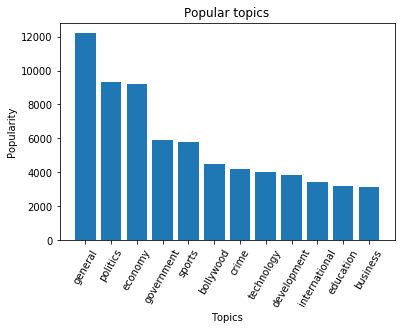

In [139]:
##plotting on bar graph
#creating labels
import matplotlib.pyplot as plt
import numpy as np
index=np.arange(len(x_topics))
plt.bar(index, y_values)
plt.xlabel('Topics', fontsize=10)
plt.ylabel('Popularity', fontsize=10)
plt.xticks(index, x_topics, fontsize=10, rotation=60)
plt.title('Popular topics')
plt.show()

This shows the Popular topics in the entire Dataset from the above dataset and assuming that the input data isnt bias <br>
it is reasonable to deduce that majority of the indian news focuses on the events regarding <br> Parliament,Government Policies and Politics<br>

To Perform the analysis on time we have to first create a dataset which has time dimensions

In [144]:
def getDay(text):
    f='%Y-%m-%d'
    text=str(text).split(' ')[0]
    if '$' in text:
        text=text[1:]
    currdate=datetime.datetime.strptime(text, f).date()
    return currdate.day

In [145]:
def getMonth(text):
    f='%Y-%m-%d'
    text=str(text).split(' ')[0]
    if '$' in text:
        text=text[1:]
    currdate=datetime.datetime.strptime(text, f).date()
    return currdate.month

In [146]:
def getYear(text):
    f='%Y-%m-%d'
    text=str(text).split(' ')[0]
    if '$' in text:
        text=text[1:]
    currdate=datetime.datetime.strptime(text, f).date()
    return currdate.year

In [147]:
df['day']=df['Date'].apply(lambda x:getDay(x))
df['month']=df['Date'].apply(lambda x:getMonth(x))
df['year']=df['Date'].apply(lambda x:getYear(x))

In [148]:
df[['Date','day','month','year']].head()

,Date,day,month,year
0,2017-01-01 00:00:00,1,1,2017
1,2017-01-01 00:00:00,1,1,2017
2,2017-01-01 00:00:00,1,1,2017
3,2017-01-01 00:00:00,1,1,2017
4,2017-04-15 00:00:00,15,4,2017


In [149]:
g1=pd.DataFrame({'count' : df.groupby( [ "topics", "month"] ).size()}).reset_index()

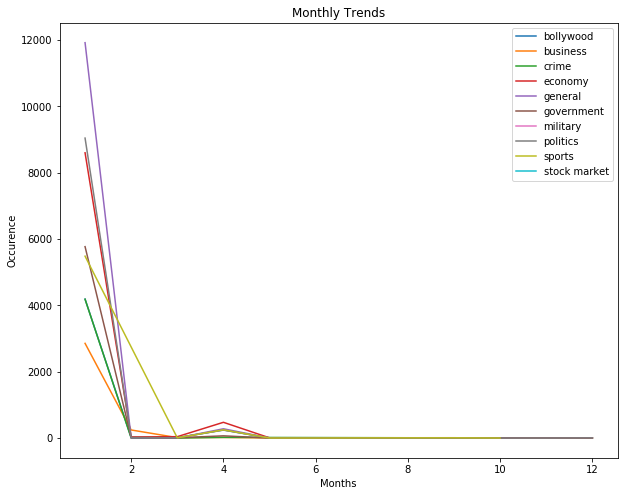

In [150]:

##graph
x1=g1[g1['topics']=='bollywood']['month'].values
x2=g1[g1['topics']=='business']['month'].values
x3=g1[g1['topics']=='crime']['month'].values
x4=g1[g1['topics']=='economy']['month'].values
x5=g1[g1['topics']=='general']['month'].values
x6=g1[g1['topics']=='government']['month'].values
x7=g1[g1['topics']=='military']['month'].values
x8=g1[g1['topics']=='politics']['month'].values
x9=g1[g1['topics']=='sports']['month'].values
x10=g1[g1['topics']=='stock market']['month'].values


y1=g1[g1['topics']=='bollywood']['count'].values
y2=g1[g1['topics']=='business']['count'].values
y3=g1[g1['topics']=='crime']['count'].values
y4=g1[g1['topics']=='economy']['count'].values
y5=g1[g1['topics']=='general']['count'].values
y6=g1[g1['topics']=='government']['count'].values
y7=g1[g1['topics']=='military']['count'].values
y8=g1[g1['topics']=='politics']['count'].values
y9=g1[g1['topics']=='sports']['count'].values
y10=g1[g1['topics']=='stock market']['count'].values

plt.plot(x1,y1,label='bollywood')
plt.plot(x2,y2,label='business')
plt.plot(x3,y3,label='crime')
plt.plot(x4,y4,label='economy')
plt.plot(x5,y5,label='general')
plt.plot(x6,y6,label='government')
plt.plot(x7,y7,label='military')
plt.plot(x8,y8,label='politics')
plt.plot(x9,y9,label='sports')
plt.plot(x10,y10,label='stock market')
plt.xlabel('Months')
plt.ylabel('Occurence')
plt.title('Monthly Trends')
plt.gcf().set_size_inches(10, 8)
plt.savefig('Trends.jpg')
plt.legend()




## Popular persons

In this section we will try to look at Popular Persons in the entire dataset

In [151]:
##important checkpoint
listPerson=df['PERSON'].values.tolist()

In [152]:
listPerson1=list(filter(bool,listPerson))

In [153]:
listPerson1=','.join(listPerson1)

In [154]:
listPerson1=listPerson1.replace(',Modi',',Narendra Modi')

In [155]:
listPerson1=listPerson1.replace(',Narendra Modis',',Narendra Modi')

In [156]:
listPerson1=listPerson1.replace(',Date','')

In [157]:
listPerson1=listPerson1.replace(',Jan','')

In [158]:
listPerson1=listPerson1.replace(',Yadav',',Akhilesh Yadav')
listPerson1=listPerson1.replace(',Singh',',Mulayam Singh')

In [159]:
new_listPerson1=""
iterator=listPerson1.split(',')
for word in iterator:
    if len(word.split(' '))==1:
        for existing_word in iterator:
            if word in existing_word:
                word=existing_word
                new_listPerson1+=word+","
    elif word[-1]=='s':
        word=word[:-1]
        new_listPerson1+=word+","
    else:
        new_listPerson1+=word+","
            

In [160]:
new_listPerson1=new_listPerson1.replace(',Embargo Syndicate Hide',"")

In [161]:
new_listPerson1=new_listPerson1.replace(',Donald Trumps',",Donald Trump")

In [162]:
new_listPerson1=new_listPerson1.replace(',Narendra Modis',",Narendra Modi")

In [163]:
new_listPerson1=new_listPerson1.replace(',Barack Obamas',",Barack Obama")

In [164]:
new_listPerson1=new_listPerson1.replace(',Kejriwals',",Arvind Kejriwal")

In [165]:
new_listPerson1=new_listPerson1.replace(',Arvind Kejriwals',",Arvind Kejriwal")

In [173]:
new_listPerson1=new_listPerson1.replace(',Article Images Short',",")

In [174]:
new_listPerson1=new_listPerson1.replace(',Mahendra Singh Dhonis',",Mahendra Singh Dhoni")

In [ ]:
new_listPerson1

## Popular Persons

In [219]:
counter = Counter(new_listPerson1.split(','))

In [220]:
new_count=counter.most_common(20)

In [221]:
# iterator=PersonCounter.items()
# TrendCount ={}
# for key,value in iterator:
#     t_count=0
#     #t_count=sum(value.values())
#     for word in value:
#         word=word[1]
#         t_count+=word
#     TrendCount[key]=t_count

In [222]:
# import operator
# sorted_x = sorted(TrendCount.items(), key=operator.itemgetter(1))
# sorted_x.reverse()
# print(sorted_x)

In [223]:
import matplotlib.pyplot as plt
import numpy as np

In [224]:
persons=[i[0] for i in new_count[:10]]
values=[i[1] for i in new_count[:10]]

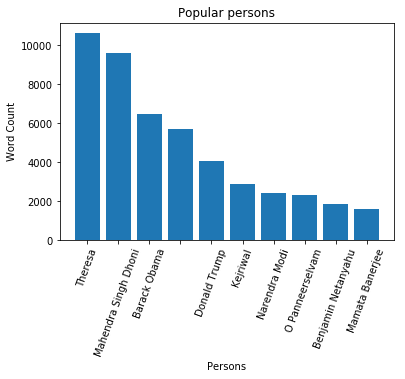

In [228]:
##plotting on bar graph
#creating labels

index=np.arange(len(persons))
plt.bar(index, values)
plt.xlabel('Persons', fontsize=10)
plt.ylabel('Word Count', fontsize=10)
plt.xticks(index, persons, fontsize=10, rotation=70)
plt.title('Popular persons')
plt.show()

In [182]:
listPerson2=set(new_listPerson1.split(','))

In [ ]:
listPerson2

In [184]:
len(listPerson2)

43995

In [185]:
#DictionaryPerson = pd.Series(df.tokens.values,index=df.PERSON).to_dict()

In [186]:
df.dtypes

index                   int64
url                    object
source                 object
crawl_time             object
title                  object
trimmed_description    object
summary                object
city                   object
state                  object
Date                   object
PERSON                 object
ORGANIZATION           object
LOCATION               object
tokens                 object
topics                 object
day                     int64
month                   int64
year                    int64
dtype: object

In [187]:
PersonDataFrame=df[['PERSON','tokens']]

In [188]:
DictionaryPerson={}
for index,values in PersonDataFrame.iterrows():
    values=values.values
    key=values[0]
    values=values[1]
    if key=='':
        key='empty'
    if key in DictionaryPerson:
        DictionaryPerson[key]=DictionaryPerson[key]+values
    else:
        DictionaryPerson[key]=values

In [ ]:
DictionaryPerson

In [189]:
iterator=DictionaryPerson.items() ## takes alot of time aswell
DictionaryPersonlist={}
for item in listPerson2:
    for key,value in iterator:
        if item.lower() in key.lower():
            if item in DictionaryPersonlist:
                DictionaryPersonlist[item]=DictionaryPersonlist[item]+DictionaryPerson[key]
            else:
                DictionaryPersonlist[item]=DictionaryPerson[key]

In [190]:
# for key,values in DictionaryPerson.items():
#     if 'Aamir'.lower() in key.lower():
#         print(key,DictionaryPerson[key])
DictionaryPersonlist

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [191]:
PersonCounter={}
iterator=DictionaryPersonlist.items()
for key,value in iterator:
    PersonCounter[key]=Counter(value).most_common(10)

In [192]:
## Counter with top 5 words because the entire word list is breaking the output screen
PersonCounter['Theresa']

[('percent', 418),
 ('said', 363),
 ('brexit', 262),
 ('european', 219),
 ('would', 216),
 ('minister', 210),
 ('us', 208),
 ('britain', 203),
 ('ket', 191),
 ('prime', 185)]

In [193]:
PersonCounter['Mahendra Singh Dhoni']

[('dhoni', 469),
 ('singh', 317),
 ('india', 306),
 ('captain', 270),
 ('mahendra', 234),
 ('kohli', 234),
 ('team', 221),
 ('england', 213),
 ('cricket', 163),
 ('first', 148)]

In [194]:
PersonCounter['Narendra Modi']

[('minister', 3660),
 ('said', 3264),
 ('prime', 2650),
 ('modi', 2507),
 ('narendra', 1819),
 ('india', 1295),
 ('government', 1256),
 ('also', 1098),
 ('party', 1069),
 ('state', 992)]

In [195]:
PersonCounter['Mamata Banerjee']

[('said', 395),
 ('minister', 377),
 ('mamata', 274),
 ('banerjee', 271),
 ('bjp', 221),
 ('tmc', 214),
 ('chief', 211),
 ('modi', 208),
 ('government', 179),
 ('party', 179)]

In [196]:
PersonCounter['O Panneerselvam']

[('minister', 506),
 ('jallikattu', 424),
 ('said', 358),
 ('chief', 322),
 ('panneerselvam', 293),
 ('state', 271),
 ('government', 261),
 ('sport', 210),
 ('prime', 187),
 ('court', 183)]

In [197]:
PersonCounter['Barack Obama']

[('obama', 727),
 ('president', 712),
 ('said', 697),
 ('us', 684),
 ('trump', 465),
 ('barack', 448),
 ('donald', 246),
 ('would', 198),
 ('house', 184),
 ('years', 176)]

In [200]:
PersonCounter['Benjamin Netanyahu']

[('netanyahu', 96),
 ('israeli', 75),
 ('minister', 71),
 ('prime', 67),
 ('benjamin', 61),
 ('said', 54),
 ('jerusalem', 49),
 ('police', 47),
 ('israel', 34),
 ('media', 31)]

In [201]:
PersonCounter['Kejriwal']

[('kejriwal', 473),
 ('said', 410),
 ('minister', 366),
 ('chief', 361),
 ('aap', 322),
 ('nd', 233),
 ('party', 216),
 ('government', 206),
 ('also', 189),
 ('people', 169)]